# FG_Detector_v1
**An organic functional group detector using Tensorflow's object detection API.**

By **Davis Thomas Daniel**

Email :  forall2087@gmail.com


In organic chemistry, [functional groups](https://en.wikipedia.org/wiki/Functional_group) are specific substituents or moieties 
within molecules that may be responsible for the characteristic chemical reactions of those molecules.

FG detector is chemical fucntional group object detector based on Tensorflow object detection API. 
The detection model was trained using transfer learning from 'ssd_efficientdet_d0_512x512_coco17_tpu-8'.  

The training dataset comprised of 300x300 sized .png images from PubChem.
Currently, the model detects the following groups : 
* Alcohol
* Aldehyde
* Amine
* Amide
* Carboxylic Acid
* Ester
* Ether
* Ketone
* Double bonds
* Benzene Ring
* Halogen
* Thiol


*Use shift+enter to run each cell, Run all cells.*

1. Don't change an of the defined paths.
2. The function `detect_fg()` downloads an image from pubchem if no filepath is given. Of course, you can also run with an image path specified. Two examples runs are done at the end.
3. All cells should be run sequentially and should not give out any errors.
4. Changing the runtime to 'GPU' is not really necessary. 

*Detection time with GPU : ~0.06s*

*Detection time without GPU : ~0.40s* 

Note : I use `pubchempy` module for getting the PubChem images. Here's is the github [page](https://github.com/mcs07/PubChemPy).

### **Download all required files and repositories.**


In [ ]:
!pip install pubchempy
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/davistdaniel/models

### **Set up the object detection API**

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

# Expect a Long output,many warnings,Never mind unless it shows errors.

### **Download the trained model**

In [ ]:
!rm -rf /content/Functional_Group_Detector_using_Tensorflow_object_detection
!git clone https://github.com/davistdaniel/Functional_Group_Detector_using_Tensorflow_object_detection.git

In [4]:
# Don't change these paths.
checkpoint_dir = '/content/Functional_Group_Detector_using_Tensorflow_object_detection/EXPORTED_model_based_on_ssd_efficientdet_d0_512x512_coco17_tpu-8/checkpoint' # enther saved models checkpoint path here.
pipeline_file = '/content/Functional_Group_Detector_using_Tensorflow_object_detection/EXPORTED_model_based_on_ssd_efficientdet_d0_512x512_coco17_tpu-8/pipeline.config' # enter saved models pipeline config path here.

In [35]:

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from tensorflow import keras
import glob
import random
import cv2
import time
import textwrap
import pubchempy as pcp
import shutil
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

### **Restore a saved model and define a prediction function.**

You will see a lot of warnings in the output, never mind.

In [6]:
# Loading the trained model for detections

pipeline_config = pipeline_file
model_dir = tf.train.latest_checkpoint(checkpoint_dir)
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(tf.train.latest_checkpoint(checkpoint_dir))

# defining a detect function
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)


# This is needed for plotting.
label_map_path = '/content/Functional_Group_Detector_using_Tensorflow_object_detection/annotations/label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### **A function for detection and saving at once.**

In [48]:
def detect_fg(img_path=None,out_path = 'detected_img.png',save_file=False,threshold=0.50,save_fig=False,coumpound_id_number=None):
 
  script_start = time.time()
  
  #some initial stuff
  from prettytable import PrettyTable
  iupacname = ''
  
  # selecting random molecule if img_path is None
  if img_path==None:
 
    ## getting a random cid.
    cid = random.choice(range(random.choice(range(25,15000)),random.choice(range(15000,150000))))
    c = pcp.Compound.from_cid(cid)
    
    ## some text printed
    print('No image path given, selecting a random molecule from pubchem with cid : '
    +str(cid)
    +'\n\n Here are some details about the compound : \n')

    # the random molecule is downloaded.
    pcp.download('PNG', '/content/random_compound.png', cid, overwrite=True)

    # image path is set.
    img_path = '/content/random_compound.png'

    # table with chemical characteristics of the compound.
    table0 = PrettyTable(['Property','Value'])
    table0.add_row(['Molecular Formula',c.molecular_formula])
    table0.add_row(['Molecular Weight',c.molecular_weight])
    table0.add_row(['IUPAC name',textwrap.fill(c.iupac_name,25)])
    table0.add_row(['Isomeric smiles',textwrap.fill(c.isomeric_smiles,25)])
    print(table0)
  
  # if image path is not None, check if the file name only has a cid.
  if img_path.split('/')[-1].split('.')[0].isdigit() and coumpound_id_number==None:
    cid = int(img_path.split('/')[-1].split('.')[0])
    print('Getting compound details for the cid number : '+str(cid)+' from PubChem.')
    c = pcp.Compound.from_cid(cid)
    
    table0 = PrettyTable(['Property','Value'])
    table0.add_row(['Molecular Formula',c.molecular_formula])
    table0.add_row(['Molecular Weight',c.molecular_weight])
    table0.add_row(['IUPAC name',textwrap.fill(c.iupac_name,25)])
    table0.add_row(['Isomeric smiles',textwrap.fill(c.isomeric_smiles,25)])
    print(table0)
  
  if coumpound_id_number !=None:
    cid = coumpound_id_number
    c = pcp.Compound.from_cid(cid)
    print('Compound details for cid number : '+str(cid)+' obtained from PubChem\n')
    table0 = PrettyTable(['Property','Value'])
    table0.add_row(['Molecular Formula',c.molecular_formula])
    table0.add_row(['Molecular Weight',c.molecular_weight])
    table0.add_row(['IUPAC name',textwrap.fill(c.iupac_name,25)])
    table0.add_row(['Isomeric smiles',textwrap.fill(c.isomeric_smiles,25)])
    print(table0)

  
  # starting detection
  
  
  print('\nDetecting on '+img_path.split('/')[-1]+'\n')
  
  img = keras.preprocessing.image.load_img(img_path, target_size=None)
  image_np = keras.preprocessing.image.img_to_array(img)

  # Convert image to grayscale

  image_np = np.tile(
      np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
  
  #generate the input tensor
  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)

  #detect
  start_time = time.time() # start_time
  detections, predictions_dict, shapes = detect_fn(input_tensor)
  end_time = time.time() # end_time

  time_taken = end_time-start_time
  #making a copy of image
  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  # setting some arrays
  detection_scores = detections['detection_scores'][0]
  detection_classes = detections['detection_classes'][0]
  
  # Making a table of detections
  table1 = PrettyTable(['Functional Group',
                        'Confidence (%)',
                        'Bounding Box Coordinates'])
  
  for i in range(len(detection_scores)):
    if detection_scores[i].numpy() > threshold:
      table1.add_row([category_index[detection_classes[i].numpy()+1]['name'],
                      detection_scores[i].numpy()*100,
                      str(np.round(detections['detection_boxes'][0].numpy()[i]*100,3))])
      
      # legend_array.append(category_index[detection_classes[i].numpy()+1]['name']
      #       +' : '+str(detection_scores[i].numpy()*100))
      # print(category_index[detection_classes[i].numpy()+1]['name']
      #       +' : '+str(detection_scores[i].numpy()*100)+' : '+str(np.round(detections['detection_boxes'][0].numpy()[i]*100,3)))
  
  print(table1)   
  
  
  #plotting
  img_detected = viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=threshold,
        agnostic_mode=False,
  )

  if save_file==True:
    cv2.imwrite(out_path,img_detected)
  
  fig,ax = plt.subplots(1,2,figsize=(14,6))
  ax[0].imshow(img)
  ax[0].set_title('Original Image')
  ax[1].imshow(image_np_with_detections)
  ax[1].set_title('Image with detections')
  if save_fig==True:
    fig.savefig(out_path)
  # plt.tight_layout()
  plt.show()
  script_end = time.time()
  print('Time taken for detection : '+str(round(time_taken,4))+'s\n')
  print('Time taken for whole script : '+str(round(script_end-script_start,4))+'s')

### **Detections**

No image path given, selecting a random molecule from pubchem with cid : 38545

 Here are some details about the compound : 

+-------------------+---------------------------+
|      Property     |           Value           |
+-------------------+---------------------------+
| Molecular Formula |         C12H17BrIN        |
|  Molecular Weight |           382.08          |
|     IUPAC name    | N-[(2-bromophenyl)methyl] |
|                   | -N-ethyl-3-iodopropan-1-a |
|                   |            mine           |
|  Isomeric smiles  |  CCN(CCCI)CC1=CC=CC=C1Br  |
+-------------------+---------------------------+

Detecting on random_compound.png

+------------------+-------------------+-------------------------------+
| Functional Group |   Confidence (%)  |    Bounding Box Coordinates   |
+------------------+-------------------+-------------------------------+
|   benzene_ring   |  97.0211386680603 | [60.2   31.126 84.625 53.425] |
|     halogen      |  80.7228684425354 | [ 7.28

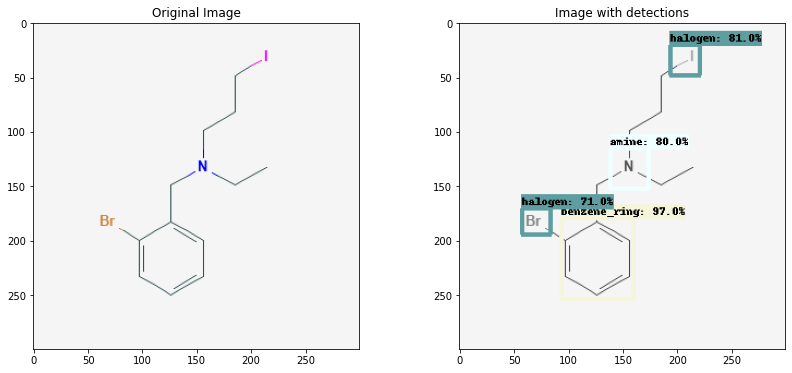

Time taken for detection : 0.4273s

Time taken for whole script : 2.9709s


In [55]:
detect_fg() # Use this for detection. The very first detection you run takes a bit longer. You can see the time taken printed at the end.

Getting compound details for the cid number : 90671 from PubChem.
+-------------------+--------------------------+
|      Property     |          Value           |
+-------------------+--------------------------+
| Molecular Formula |         C6H4Cl2S         |
|  Molecular Weight |          179.07          |
|     IUPAC name    | 2,6-dichlorobenzenethiol |
|  Isomeric smiles  |  C1=CC(=C(C(=C1)Cl)S)Cl  |
+-------------------+--------------------------+

Detecting on 90671.png

+------------------+-------------------+-------------------------------+
| Functional Group |   Confidence (%)  |    Bounding Box Coordinates   |
+------------------+-------------------+-------------------------------+
|   benzene_ring   | 91.56619310379028 | [42.036 38.823 66.463 61.153] |
|      thiol       | 84.68292355537415 | [23.042 47.218 35.392 58.807] |
|     halogen      |  77.688068151474  | [38.156 27.747 47.284 35.764] |
|     halogen      | 76.06854438781738 | [38.434 66.289 46.337 73.423] |
+-----

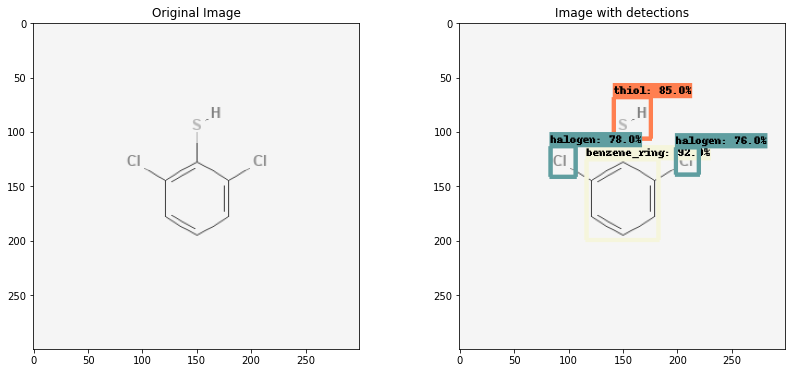

Time taken for detection : 0.4372s

Time taken for whole script : 1.9117s


In [56]:
# You can also use a an image file from /content/Functional_Group_Detector_using_Tensorflow_object_detection/test_images folder
# currently I have set it to choose a random image from the folder.

detect_fg(random.choice(glob.glob('/content/Functional_Group_Detector_using_Tensorflow_object_detection/test_images/*.png')))

Getting compound details for the cid number : 8184 from PubChem.
+-------------------+--------------+
|      Property     |    Value     |
+-------------------+--------------+
| Molecular Formula |   C11H24O    |
|  Molecular Weight |    172.31    |
|     IUPAC name    | undecan-1-ol |
|  Isomeric smiles  | CCCCCCCCCCCO |
+-------------------+--------------+

Detecting on 8184.png

+------------------+-------------------+-------------------------------+
| Functional Group |   Confidence (%)  |    Bounding Box Coordinates   |
+------------------+-------------------+-------------------------------+
|     alcohol      | 83.39191675186157 | [45.112  3.092 52.623 14.628] |
+------------------+-------------------+-------------------------------+


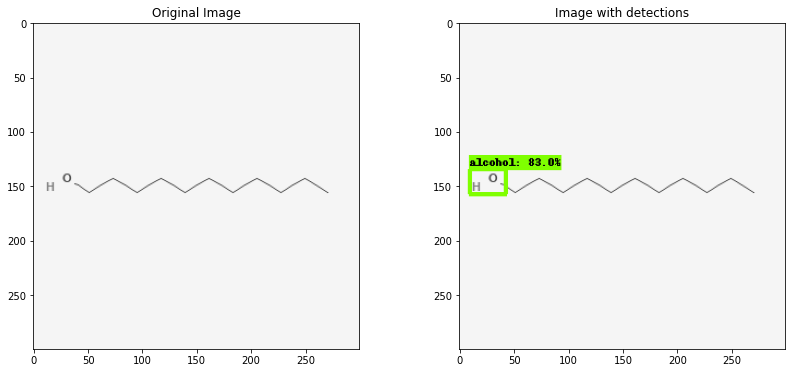

Time taken for detection : 0.4232s

Time taken for whole script : 2.0757s


In [52]:
detect_fg('/content/Functional_Group_Detector_using_Tensorflow_object_detection/test_images/8184.png')